In [1]:
import math
import gmsh
import numpy as np
from scipy.sparse import lil_matrix
from matspy import spy
from scipy.sparse.linalg import eigs, spsolve
import matplotlib.pyplot as plt
from collections import defaultdict

### Create the Mesh using GMSH

In [2]:
# Meshing density control
lc = 0.05

gmsh.initialize()

# Define rectangle surface
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(3, 0, 0, lc, 2)
gmsh.model.geo.addPoint(3, 0.5, 0, lc, 3)
gmsh.model.geo.addPoint(0, 0.5, 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(3, 2, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
gmsh.model.geo.addCurveLoop([4, 1, -2, 3], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

# Extrude Rectangle
ov2 = gmsh.model.geo.extrude([(2, 1)], 0, 0, 0.75)

# Generate Mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(3)

#gmsh.fltk.run()

### View Mesh

In [3]:
gmsh.fltk.run()

### Local Matrix Generation Functions

#### 3D Case

In [4]:
LOCAL_EDGE_NODES_3D = np.array([[1, 2],
                                [1, 3],
                                [1, 4],
                                [2, 3],
                                [2, 4],
                                [3, 4]])

""" 
Coordinates are expected in this form:
[[x1 y1 z1],
 [x2 y2 z2],
 [x3 y3 z3],
 [x4 y4 z4]]
"""

"""
Simplex coefficients are expected in this form:
[[b1 c1 d1 a1],
 [b2 c2 d2 a2],
 [b3 c3 d3 a3],
 [b4 c4 d4 a4]]
"""

def get_volume(coordinates):
    mat = np.hstack((np.ones((4, 1)), coordinates))
    return np.abs(np.linalg.det(mat)/6)

def get_simplex_coefficients_3d(coordinates):
    mat = coordinates.T
    mat = np.vstack([mat, [1,1,1,1]])
    return np.linalg.inv(mat)

def v_3d(i, j, simplex_coefficients):
    return np.cross(simplex_coefficients[i-1][:3], simplex_coefficients[j-1][:3])

def phi_3d(i, j, simplex_coefficients):
    return np.dot(simplex_coefficients[i-1][:3], simplex_coefficients[j-1][:3])

M_3d = np.array([[2, 1, 1, 1],
                 [1, 2, 1, 1],
                 [1, 1, 2, 1],
                 [1, 1, 1, 2]]) / 20

def S_and_T_3d(coordinates):
    S = np.zeros((6,6), dtype="complex")
    T = np.zeros((6,6), dtype="complex")
    volume = get_volume(coordinates)
    simplex_coefficients = get_simplex_coefficients_3d(coordinates)
    for ii in range(0,6):
        for jj in range(0,6):
            i1 = LOCAL_EDGE_NODES_3D[ii,0];
            i2 = LOCAL_EDGE_NODES_3D[ii,1];
            j1 = LOCAL_EDGE_NODES_3D[jj,0];
            j2 = LOCAL_EDGE_NODES_3D[jj,1];
            S[ii,jj] = 4*volume*np.dot(v_3d(i1,i2, simplex_coefficients), v_3d(j1,j2, simplex_coefficients))
            T[ii,jj] = volume*(phi_3d(i2, j2, simplex_coefficients)*M_3d[i1-1, j1-1] - phi_3d(i2, j1, simplex_coefficients)*M_3d[i1-1, j2-1] - phi_3d(i1, j2, simplex_coefficients)*M_3d[i2-1, j1-1] + phi_3d(i1, j1, simplex_coefficients)*M_3d[i2-1, j2-1])
    return S, T


#### 2D Case

In [5]:
LOCAL_EDGE_NODES_2D = np.array([[1, 2],
                                [1, 3],
                                [2, 3]])

""" 
Coordinates are expected in this form:
[[x1 y1],
 [x2 y2],
 [x3 y3]]
"""

"""
Simplex coefficients are expected in this form:
[[b1 c1 a1],
 [b2 c2 a2],
 [b3 c3 a3]]
"""

def get_area(coordinates):
    mat = np.hstack((np.ones((3, 1)), coordinates))
    return np.abs(np.linalg.det(mat)/2)

def get_simplex_coefficients_2d(coordinates):
    mat = coordinates.T
    mat = np.vstack([mat, [1,1,1]])
    return np.linalg.inv(mat)

def v_2d(i, j, simplex_coefficients):
    b_i = simplex_coefficients[i-1][0]
    b_j = simplex_coefficients[j-1][0]
    c_i = simplex_coefficients[i-1][1]
    c_j = simplex_coefficients[j-1][1]
    return b_i*c_j - b_j*c_i

def phi_2d(i, j, simplex_coefficients):
    return np.dot(simplex_coefficients[i-1][:2], simplex_coefficients[j-1][:2])

M = np.array([[2, 1, 1],
              [1, 2, 1],
              [1, 1, 2]]) / 12

def S_and_T_2d(coordinates):
    S = np.zeros((3,3), dtype="complex")
    T = np.zeros((3,3), dtype="complex")
    area = get_area(coordinates)
    simplex_coefficients = get_simplex_coefficients_2d(coordinates)
    for ii in range(0,3):
        for jj in range(0,3):
            i1 = LOCAL_EDGE_NODES_2D[ii,0];
            i2 = LOCAL_EDGE_NODES_2D[ii,1];
            j1 = LOCAL_EDGE_NODES_2D[jj,0];
            j2 = LOCAL_EDGE_NODES_2D[jj,1];
            S[ii,jj] = 4*area*v_2d(i1,i2, simplex_coefficients)*v_2d(j1,j2, simplex_coefficients)
            T[ii,jj] = area*(phi_2d(i2, j2, simplex_coefficients)*M[i1-1, j1-1] - phi_2d(i2, j1, simplex_coefficients)*M[i1-1, j2-1] - phi_2d(i1, j2, simplex_coefficients)*M[i2-1, j1-1] + phi_2d(i1, j1, simplex_coefficients)*M[i2-1, j2-1])
    return S, T


### Peform Mesh Bookeeping

In [6]:
def create_lookup_table(nodeTags):
    nodeTagsMap = -1 * np.ones(nodeTags.max(), dtype="int")
    for i, node in enumerate(nodeTags):
        nodeTagsMap[int(node-1)] = i
    return nodeTagsMap

In [7]:
nodeTags, nodeCoords, _ = gmsh.model.mesh.getNodes(dim=3, includeBoundary=True)
elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(3)
gmsh.model.mesh.createEdges()
edgeTags, _ = gmsh.model.mesh.getAllEdges()
elemTags = elemTags[0]
num_edges = len(edgeTags)

# Reshape coordinates and node tags.
nodeCoords = np.reshape(nodeCoords, (-1, 3))
elemNodeTags = np.reshape(elemNodeTags, (-1, 4))

elemNodeTags.sort(axis=1)

# Create a datastructure to lookup index of a given node.
nodeTagsMap = create_lookup_table(nodeTags)
elemTagsMap = create_lookup_table(elemTags)

### Helper Functions

In [8]:
def get_global_edge_2d(j, nodes):
    local_edge_nodes_j = LOCAL_EDGE_NODES_2D[j];
    global_edge_nodes_j = nodes[local_edge_nodes_j-1]
    jj, _ = gmsh.model.mesh.getEdges(global_edge_nodes_j)
    jj = int(jj[0])

    return jj, global_edge_nodes_j

In [9]:
def get_global_edge_3d(j, nodes):
    local_edge_nodes_j = LOCAL_EDGE_NODES_3D[j];
    global_edge_nodes_j = nodes[local_edge_nodes_j-1]
    jj, _ = gmsh.model.mesh.getEdges(global_edge_nodes_j)
    jj = int(jj[0])

    return jj, global_edge_nodes_j

In [10]:
def get_elem_coords_2d(nodes, nodeTagsMap, nodeCoords):
    coords = np.zeros((3,3))
    for i, node in enumerate(nodes):
        node_index = int(nodeTagsMap[int(node-1)])
        coords[i] = nodeCoords[node_index]

    return coords

In [11]:
def get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords):
    coords = np.zeros((4,3))
    for i, node in enumerate(nodes):
        node_index = int(nodeTagsMap[int(node-1)])
        coords[i] = nodeCoords[node_index]

    return coords

### Solve Port Eigenfunctions

#### Find Elements on Port

Port is on face where x=0

In [12]:
def both_nodes_are_port(nodes, nodeTagsMap, nodeCoords, tol=1e-3):
    node1_index = int(nodeTagsMap[int(nodes[0]-1)])
    node2_index = int(nodeTagsMap[int(nodes[1]-1)])

    coord1 = nodeCoords[node1_index]
    coord2 = nodeCoords[node2_index]

    if math.isclose(coord1[0], 0.0, abs_tol=tol) and math.isclose(coord2[0], 0.0, abs_tol=tol):
        return True

    return False        

In [13]:
def both_nodes_are_port_boundary(nodes, nodeTagsMap, nodeCoords, tol=1e-3):
    node1_index = int(nodeTagsMap[int(nodes[0]-1)])
    node2_index = int(nodeTagsMap[int(nodes[1]-1)])

    coord1 = nodeCoords[node1_index]
    coord2 = nodeCoords[node2_index]
    
    if math.isclose(coord1[1], 0.0, abs_tol=tol) and math.isclose(coord2[1], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[1], 0.5, abs_tol=tol) and math.isclose(coord2[1], 0.5, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.0, abs_tol=tol) and math.isclose(coord2[2], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.75, abs_tol=tol) and math.isclose(coord2[2], 0.75, abs_tol=tol):
        return True

In [14]:
edge_is_port = np.zeros(num_edges, dtype='bool')
edge_is_port_boundary = np.zeros(num_edges, dtype='bool')
port_elements = defaultdict(set)

for e, (elem, nodes) in enumerate(zip(elemTags, elemNodeTags)):
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)

    for j in range(0,6):
        jj, global_edge_nodes_j = get_global_edge_3d(j, nodes)
        edge_is_port[jj - 1] = both_nodes_are_port(global_edge_nodes_j, nodeTagsMap, nodeCoords)        
        if (edge_is_port[jj - 1]):
            edge_is_port_boundary[jj - 1] = both_nodes_are_port_boundary(global_edge_nodes_j, nodeTagsMap, nodeCoords)
            port_elements[e].add(global_edge_nodes_j[0])
            port_elements[e].add(global_edge_nodes_j[1])

non_boundary_port_edges = edge_is_port.sum() - edge_is_port_boundary.sum()

modified_edge_port_map = -1 * np.ones(num_edges, dtype="int")
i = 0
for edge, (is_port_boundary, is_port) in enumerate(zip(edge_is_port_boundary, edge_is_port)):
    if not is_port_boundary and is_port:
        modified_edge_port_map[edge] = i
        i+=1

#### Assemble Port Matrix

In [15]:
# Loop through each element.
S = lil_matrix((non_boundary_port_edges,non_boundary_port_edges), dtype="complex")
T = lil_matrix((non_boundary_port_edges,non_boundary_port_edges), dtype="complex")
for elem, nodes in port_elements.items():
    nodes = list(nodes)
    nodes.sort()
    nodes = np.array(nodes)
    if (len(nodes) != 3):
        continue

    # Get coordinates in required form
    coords = get_elem_coords_2d(nodes, nodeTagsMap, nodeCoords)    
    coords = coords[:,1:]
    
    # Get local S and T matrices
    S_elem, T_elem = S_and_T_2d(coords)

    # Place local matrix elements in global matrix
    for j in range(0,3):
        jj, _ = get_global_edge_2d(j, nodes)
        is_j_boundary = edge_is_port_boundary[jj - 1]
        jj = modified_edge_port_map[jj - 1]
        
        for k in range(0,3):
            kk, _ = get_global_edge_2d(k, nodes)
            is_k_boundary = edge_is_port_boundary[kk - 1]
            kk = modified_edge_port_map[kk - 1]

            if not is_j_boundary and not is_k_boundary:
                
                S[jj, kk] = S[jj, kk] + S_elem[j, k]
                T[jj, kk] = T[jj, kk] + T_elem[j, k]

S = S.tocsr()
T = T.tocsr()

#### Inspect Structure of Port FEM Matrix

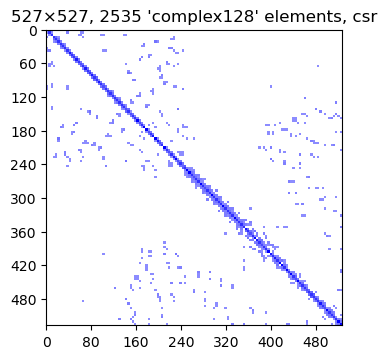

In [16]:
spy(S)

### Solve

In [17]:
mu_r = 1
e_r = 1

w, v = eigs(S / mu_r, k=10, M=e_r * T, sigma=49)

print(np.sqrt(w))
print(v.shape)

[7.55164144e+00-5.96084919e-16j 6.28345511e+00-1.64224549e-16j
 8.37845742e+00+4.87754028e-16j 4.18898591e+00-3.15766742e-16j
 1.26724585e-06-9.24387515e-09j 1.07654539e-06-2.76643098e-08j
 1.01869078e-06+1.83989294e-08j 8.98895941e-07-1.10480990e-07j
 9.27492392e-07-2.20323963e-08j 9.14784234e-07+7.41295715e-08j]
(527, 10)


### Plot Port Excitation

In [18]:
excitation_i = 3
excitation_vec = v[:,excitation_i]
excitation_k_2 = w[excitation_i]

In [19]:
''''
simplex_coords form:
[lambda_1, lambda_2, lambda_3, lambda_4]
'''
def witney(i, j, simplex_coeff, simplex_coords):
    return simplex_coords[i-1]*simplex_coeff[j-1][:3] - simplex_coords[j-1]*simplex_coeff[i-1][:3]

def eval_vec(x, y, z, nodeTagsMap, elemNodeTags, nodeCoords, data):
    elementTag, _, _, _, _, _ = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, strict=True)
    nodes = elemNodeTags[elemTagsMap[int(elementTag-1)]]
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)
    simplex_coeff = get_simplex_coefficients_3d(coords)

    simplex_coords = simplex_coeff @ np.array([x,y,z,1])
    
    result = np.zeros(3, dtype="complex")
    for j in range(0,6):
        edge_nodes = LOCAL_EDGE_NODES_3D[j]
        jj, _ = get_global_edge_3d(j, nodes)
        is_j_port_boundary = edge_is_port_boundary[jj - 1]
        is_j_port = edge_is_port[jj - 1]
        if (is_j_port and is_j_port_boundary):
            continue
        if not is_j_port:
            continue
        jj = modified_edge_port_map[jj - 1]
        result = result + data[jj] * witney(edge_nodes[0], edge_nodes[1], simplex_coeff, simplex_coords)
        
    return result

steps = 20
results = np.zeros((steps, steps, 3),dtype="complex")

X = np.zeros((steps * steps))
Y = np.zeros((steps * steps))
U = np.zeros((steps * steps))
V = np.zeros((steps * steps))

for i, x in enumerate(np.linspace(0,0.5,steps)):
    for j, y in enumerate(np.linspace(0,0.75,steps)):
        results[i, j] = eval_vec(0, x, y, nodeTagsMap, elemNodeTags, nodeCoords, excitation_vec)
        X[i + steps*j] = x
        Y[i + steps*j] = y
        U[i + steps*j] = np.real(results[i, j][1])
        V[i + steps*j] = np.real(results[i, j][2])

Text(0.5, 1.0, 'E Field Vectors')

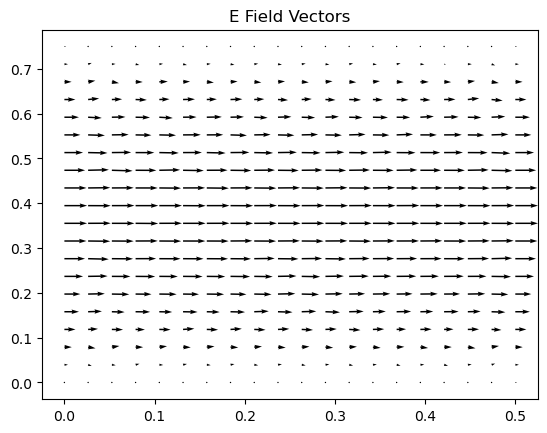

In [20]:
plt.figure()
plt.quiver(X,Y,U,V)
plt.title("E Field Vectors")

### Solve Full Problem

In [21]:
def both_nodes_are_boundary(nodes, nodeTagsMap, nodeCoords, tol=1e-3):
    node1_index = int(nodeTagsMap[int(nodes[0]-1)])
    node2_index = int(nodeTagsMap[int(nodes[1]-1)])

    coord1 = nodeCoords[node1_index]
    coord2 = nodeCoords[node2_index]

    if math.isclose(coord1[0], 0.0, abs_tol=tol) and math.isclose(coord2[0], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[0], 1.0, abs_tol=tol) and math.isclose(coord2[0], 1.0, abs_tol=tol):
        return True
    if math.isclose(coord1[1], 0.0, abs_tol=tol) and math.isclose(coord2[1], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[1], 0.5, abs_tol=tol) and math.isclose(coord2[1], 0.5, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.0, abs_tol=tol) and math.isclose(coord2[2], 0.0, abs_tol=tol):
        return True
    if math.isclose(coord1[2], 0.75, abs_tol=tol) and math.isclose(coord2[2], 0.75, abs_tol=tol):
        return True
    
    return False

In [22]:
edge_is_boundary = np.zeros(num_edges, dtype='bool')

for e, (elem, nodes) in enumerate(zip(elemTags, elemNodeTags)):
    # Get coordinates in required form
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)

    for j in range(0,6):
        jj, global_edge_nodes_j = get_global_edge_3d(j, nodes)
        edge_is_boundary[jj - 1] = both_nodes_are_boundary(global_edge_nodes_j, nodeTagsMap, nodeCoords)

non_boundary_edges = num_edges - edge_is_boundary.sum()

modified_edge_map = -1 * np.ones(num_edges, dtype="int")
i = 0
for edge, is_boundary in enumerate(edge_is_boundary):
    if not is_boundary:
        modified_edge_map[edge] = i
        i+=1

In [23]:
# Loop through each element.
S = lil_matrix((non_boundary_edges,non_boundary_edges), dtype="complex")
T = lil_matrix((non_boundary_edges,non_boundary_edges), dtype="complex")
b = np.zeros(non_boundary_edges, dtype="complex")

for elem, nodes in zip(elemTags, elemNodeTags):
    # Get coordinates in required form
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)

    # Get local S and T matrices
    S_elem, T_elem = S_and_T_3d(coords)

    # Place local matrix elements in global matrix
    for j in range(0,6):
        jj, _ = get_global_edge_3d(j, nodes)
        is_j_boundary = edge_is_boundary[jj - 1]
        is_j_port = edge_is_port[jj - 1]
        jj = modified_edge_map[jj - 1]
        
        for k in range(0,6):
            kk, _ = get_global_edge_3d(k, nodes)
            is_k_boundary = edge_is_boundary[kk - 1]
            is_k_port = edge_is_port[kk - 1]
            kk_save = kk
            kk = modified_edge_map[kk - 1]

            if not is_j_boundary and not is_k_boundary:                                
                S[jj, kk] = S[jj, kk] + S_elem[j, k]
                T[jj, kk] = T[jj, kk] + T_elem[j, k]

            elif not is_j_boundary and is_k_port:
                amplitude = excitation_vec[modified_edge_port_map[kk_save - 1]]
                b[jj] -= amplitude * S_elem[j, k]

S = S.tocsr()
T = T.tocsr()

In [24]:
sol = spsolve(S / mu_r - 27 * e_r * T, b)

In [25]:
'''
simplex_coords form:
[lambda_1, lambda_2, lambda_3, lambda_4]
'''

def witney(i, j, simplex_coeff, simplex_coords):
    return simplex_coords[i-1]*simplex_coeff[j-1][:3] - simplex_coords[j-1]*simplex_coeff[i-1][:3]

def eval_vec(x, y, z, nodeTagsMap, elemNodeTags, nodeCoords, data):
    elementTag, _, _, _, _, _ = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, strict=True)
    nodes = elemNodeTags[elemTagsMap[int(elementTag-1)]]
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)
    simplex_coeff = get_simplex_coefficients_3d(coords)

    simplex_coords = simplex_coeff @ np.array([x,y,z,1])
    
    result = np.zeros(3, dtype="complex")
    for j in range(0,6):
        edge_nodes = LOCAL_EDGE_NODES_3D[j]
        jj, _ = get_global_edge_3d(j, nodes)
        is_j_boundary = edge_is_boundary[jj - 1]
        if (is_j_boundary):
            continue
        jj = modified_edge_map[jj - 1]
        result = result + data[jj] * witney(edge_nodes[0], edge_nodes[1], simplex_coeff, simplex_coords)
        
    return result

steps = 20
results = np.zeros((steps, steps, 3),dtype="complex")

X = np.zeros((steps * steps))
Y = np.zeros((steps * steps))
U = np.zeros((steps * steps))
V = np.zeros((steps * steps))

for i, x in enumerate(np.linspace(0,3,steps)):
    for j, y in enumerate(np.linspace(0,0.5,steps)):
        results[i, j] = eval_vec(x, y, 0.35, nodeTagsMap, elemNodeTags, nodeCoords, sol)
        X[i + steps*j] = x
        Y[i + steps*j] = y
        U[i + steps*j] = np.real(results[i, j][0])
        V[i + steps*j] = np.real(results[i, j][1])

Text(0.5, 1.0, 'E Field Vectors')

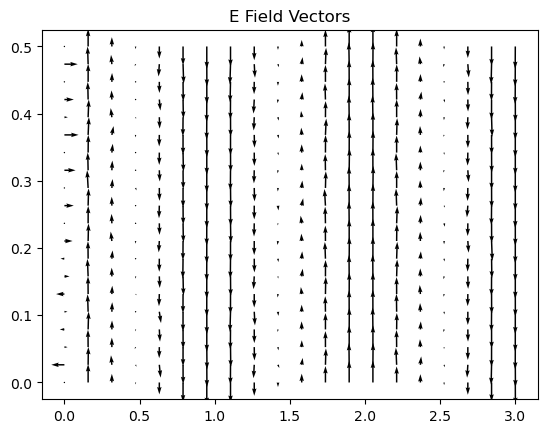

In [26]:
plt.figure()
plt.quiver(X,Y,U,V)
plt.title("E Field Vectors")

### Test

In [27]:
''''
simplex_coords form:
[lambda_1, lambda_2, lambda_3, lambda_4]
'''
def witney(i, j, simplex_coeff, simplex_coords):
    return simplex_coords[i-1]*simplex_coeff[j-1][:3] - simplex_coords[j-1]*simplex_coeff[i-1][:3]

def eval_vec(x, y, z, nodeTagsMap, elemNodeTags, nodeCoords, data):
    elementTag, _, _, _, _, _ = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, strict=True)
    nodes = elemNodeTags[elemTagsMap[int(elementTag-1)]]
    coords = get_elem_coords_3d(nodes, nodeTagsMap, nodeCoords)
    simplex_coeff = get_simplex_coefficients_3d(coords)

    simplex_coords = simplex_coeff @ np.array([x,y,z,1])
    
    result = np.zeros(3, dtype="complex")
    for j in range(0,6):
        edge_nodes = LOCAL_EDGE_NODES_3D[j]
        jj, _ = get_global_edge_3d(j, nodes)
        is_j_port_boundary = edge_is_port_boundary[jj - 1]
        is_j_port = edge_is_port[jj - 1]
        if (is_j_boundary):
            continue
        jj = modified_edge_map[jj - 1]
        result = result + data[jj] * witney(edge_nodes[0], edge_nodes[1], simplex_coeff, simplex_coords)
        
    return result

steps = 20
results = np.zeros((steps, steps, 3),dtype="complex")

X = np.zeros((steps * steps))
Y = np.zeros((steps * steps))
U = np.zeros((steps * steps))
V = np.zeros((steps * steps))

for i, x in enumerate(np.linspace(0,0.5,steps)):
    for j, y in enumerate(np.linspace(0,0.75,steps)):
        results[i, j] = eval_vec(0.1, x, y, nodeTagsMap, elemNodeTags, nodeCoords, sol)
        X[i + steps*j] = x
        Y[i + steps*j] = y
        U[i + steps*j] = np.real(results[i, j][1])
        V[i + steps*j] = np.real(results[i, j][2])

Text(0.5, 1.0, 'E Field Vectors')

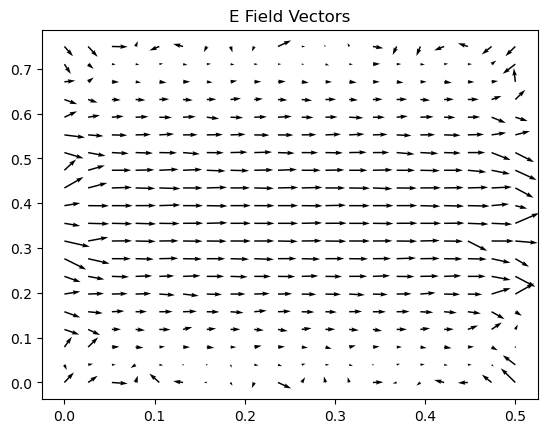

In [28]:
plt.figure()
plt.quiver(X,Y,U,V)
plt.title("E Field Vectors")

In [29]:
#gmsh.finalize()